In [1]:
%matplotlib inline

In [11]:
# all imports should go here

import pandas as pd
import sys
import os
import subprocess
import datetime
import platform
import datetime

import matplotlib.pyplot as plt
#import seaborn as sb

import  cartopy
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.io.img_tiles import StamenTerrain
from cartopy.io.img_tiles import GoogleTiles
from owslib.wmts import WebMapTileService

from matplotlib.path import Path
import matplotlib.patheffects as PathEffects
import matplotlib.patches as mpatches

from shapely.geometry import MultiLineString

import numpy as np

import tempfile
import zipfile 
import requests
import time
import pathlib
import io

In [3]:
# show info to support reproducability

def python_env_name():
    envs = subprocess.check_output('conda env list').splitlines()
    # get unicode version of binary subprocess output
    envu = [x.decode('ascii') for x in envs]
    active_env = list(filter(lambda s: '*' in str(s), envu))[0]
    env_name = str(active_env).split()[0]
    return env_name
#end python_env_name

print('python version : ' + sys.version)
print('python environment :', python_env_name())
print('pandas version : ' + pd.__version__)

print('current wkg dir: ' + os.getcwd())
print('Notebook run at: ' + str(datetime.datetime.now())+ ' local time')
print('Notebook run at: ' + str(datetime.datetime.utcnow()) + ' UTC') 
print('Notebook run on: ' + platform.platform())
print('Cartopy Version: '+ cartopy.__version__)

python version : 3.5.2 |Anaconda custom (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
python environment : root
pandas version : 0.18.1
current wkg dir: C:\Users\donrc\Documents\JupyterNotebooks\CartopyNotebookProject\develop
Notebook run at: 2017-02-13 13:47:50.370522 local time
Notebook run at: 2017-02-13 03:47:50.370522 UTC
Notebook run on: Windows-10-10.0.14393-SP0
Cartopy Version: 0.15.0


In [6]:
url = 'https://firms.modaps.eosdis.nasa.gov/active_fire/c6/shapes/zips/MODIS_C6_Australia_and_New_Zealand_24h.zip'

In [21]:
BORDERS_10m = cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land',
                              '10m', edgecolor='black', facecolor='none')
"""country boundaries."""


COASTLINE_10m = cartopy.feature.NaturalEarthFeature('physical', 'coastline', '10m',
                                edgecolor='black', facecolor='none')
"""coastline, including major islands."""


LAKES_10m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                            edgecolor='face',
                            facecolor=cartopy.feature.COLORS['water'])
""" natural and artificial lakes."""


LAND_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                           edgecolor='face',
                           facecolor=cartopy.feature.COLORS['land'])
"""land polygons, including major islands."""


OCEAN_10m = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
                            edgecolor='face',
                            facecolor=cartopy.feature.COLORS['water'])
"""Small scale (1:110m) ocean polygons."""


RIVERS_10m = cartopy.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',
                             edgecolor=cartopy.feature.COLORS['water'],
                             facecolor='none')
"""single-line drainages, including lake centerlines."""


'single-line drainages, including lake centerlines.'

In [16]:
print( 'CWD = ', os.getcwd() )
print('Getting Zip File ...')
results = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(results.content))

print('Unzipping file ...')

fire_path = '../data/fires'
z.extractall(fire_path)

# show files
p = pathlib.Path(fire_path)
_ = [print(x) for x in p.iterdir()]



CWD =  C:\Users\donrc\Documents\JupyterNotebooks\CartopyNotebookProject\develop
Getting Zip File ...
Unzipping file ...
..\data\fires\MODIS_C6_Australia_and_New_Zealand_24h.dbf
..\data\fires\MODIS_C6_Australia_and_New_Zealand_24h.shp
..\data\fires\MODIS_C6_Australia_and_New_Zealand_24h.shx


[None, None, None]

Processing Shape file ...
{'SATELLITE': 'T', 'TRACK': 1.1, 'BRIGHT_T31': 305.4, 'FRP': 18.2, 'SCAN': 1.3, 'ACQ_DATE': '20170211', 'VERSION': '6.0NRT', 'ACQ_TIME': '0040', 'BRIGHTNESS': 331.4, 'LATITUDE': -20.372, 'CONFIDENCE': 70, 'DAYNIGHT': 'D', 'LONGITUDE': 140.947}
POINT (140.947 -20.372)


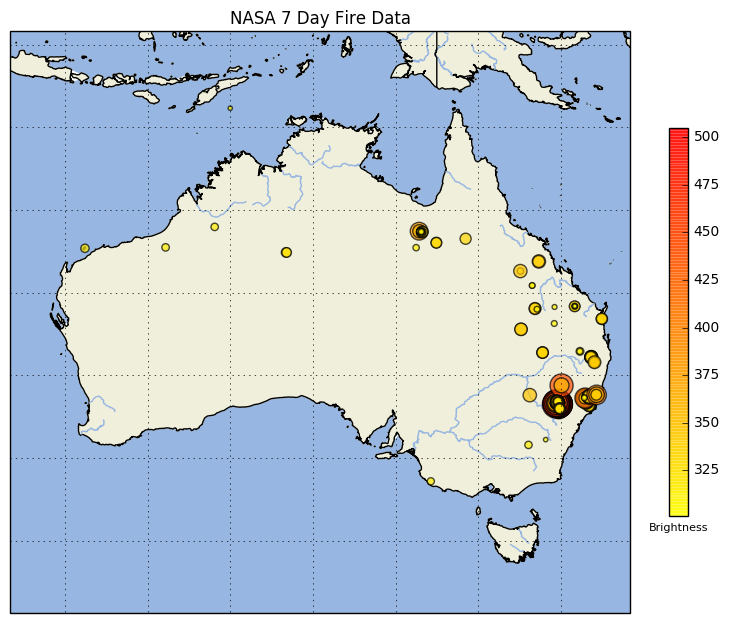

In [68]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=140))
ax.set_extent((110, 155, -45, -5))
#ax.coastlines(resolution='10m',zorder=3, linewidth=1)

ax.gridlines(draw_labels=False)

#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
#ax.add_feature(cartopy.feature.COASTLINE)
#ax.add_feature(cartopy.feature.RIVERS )
#ax.add_feature(cartopy.feature.BORDERS)

ax.add_feature(LAND_10m)
#ax.add_feature(OCEAN_10m)
ax.add_feature(COASTLINE_10m)
ax.add_feature(RIVERS_10m )
ax.add_feature(BORDERS_10m)

add_shp = fire_path+'/MODIS_C6_Australia_and_New_Zealand_24h'

shp = shapereader.Reader(add_shp)
add_s = shp.records()
ADD_alpha = 0.2

print( 'Processing Shape file ...')

xs = []
ys = []
bf = []
first = True
for add in add_s:
    if(first):
        print(add.attributes)
        print(add.geometry)
        first=False
    #end if
    if( add.geometry == None):
        pass
    else:
        bf.append(add.attributes['BRIGHTNESS'])
        xs.append(add.geometry.x)
        ys.append(add.geometry.y)
#        ax.plot(add.geometry.x,add.geometry.y,
#                 transform=ccrs.PlateCarree(),
#                    color='red', alpha = ADD_alpha, zorder=4, marker='o')
    #end if

#end for
marker = 'o'
maxb = max(bf)
minb = min(bf)
sizeb = [400*(x-minb)/(maxb-minb+1) for x in bf]
a = ax.scatter(xs,ys,marker=marker, c = bf, cmap='autumn_r', zorder = 2, s=sizeb,  transform=ccrs.Geodetic(), alpha=0.7)


ax.set_title('NASA 7 Day Fire Data')
cbar = plt.colorbar(a, shrink=0.5)
cbar.ax.set_xlabel('Brightness', size = 8)

plt.show()